# Setup

In [1]:
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import numpy as np
from fastai.vision.all import *

In [2]:
DATA = Path('../../data')
URBAN_SOUND = DATA/'urban-sound'
URBAN_SOUND_RECORDINGS = URBAN_SOUND/'data'
DATA = URBAN_SOUND/'train'
DATA.ls()

(#10) [Path('../../data/urban-sound/train/car_horn'),Path('../../data/urban-sound/train/jackhammer'),Path('../../data/urban-sound/train/siren'),Path('../../data/urban-sound/train/street_music'),Path('../../data/urban-sound/train/engine_idling'),Path('../../data/urban-sound/train/gun_shot'),Path('../../data/urban-sound/train/drilling'),Path('../../data/urban-sound/train/dog_bark'),Path('../../data/urban-sound/train/children_playing'),Path('../../data/urban-sound/train/air_conditioner')]

# Datablock and Dataloader

We want to create the datablock and dataloader to feed to our model.

In [3]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

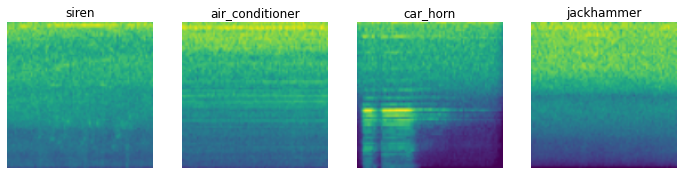

In [4]:
dls = dblock.dataloaders(DATA)
dls.valid.show_batch(max_n=4, nrows=1)

In [5]:
dls.vocab

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Transfer learning

The motivation of this model was to use transfer learning. We wanted to use the previously trained as the starting point for this new model. Since the dataset is similar, but a bit smaller we thought this would be a good dataset to test transfer learning. 

In [6]:
modelPath = Path('../models')
preTrained = load_learner(modelPath/'model_V2.pkl')

In [7]:
def get_model(model, pretrained=True):
    m = model
    return m

In [8]:
model = partial(get_model, model=preTrained.model)
m = model()
type(m)

torch.nn.modules.container.Sequential

In [9]:
learn = cnn_learner(dls, model, pretrained=True, metrics=[error_rate, accuracy])

By freezing we prevent the trained weights to be modified. 

In [10]:
learn.freeze()

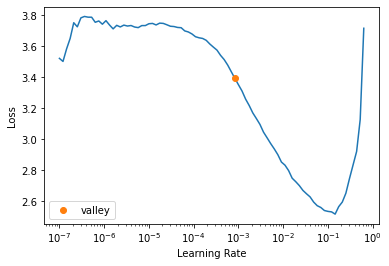

In [11]:
lr = learn.lr_find()

In [12]:
learn.fit_one_cycle(5, lr_max=slice(lr.valley))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.262326,2.604516,0.814978,0.185022,00:01
1,2.503522,1.530445,0.431718,0.568282,00:01
2,2.078176,1.194772,0.361233,0.638767,00:01
3,1.811945,1.157064,0.365639,0.634361,00:01
4,1.666613,1.147409,0.370044,0.629956,00:01


By unfreezing all the layers are now trainable. All of the previously frozen layers can now be updated according to the loss function.

In [13]:
learn.unfreeze()

In [14]:
learn.fit_one_cycle(8, lr_max=slice(lr.valley))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.264419,1.093864,0.339207,0.660793,00:01
1,1.239807,1.064134,0.295154,0.704846,00:01
2,1.144905,1.007476,0.295154,0.704846,00:01
3,1.077574,1.023811,0.273128,0.726872,00:01
4,0.986150,0.969213,0.281938,0.718062,00:01
5,0.901502,0.932772,0.251101,0.748899,00:01
6,0.861237,0.916230,0.251101,0.748899,00:01
7,0.812662,0.909483,0.251101,0.748899,00:01


# Evaluation

As we can see below, using the pretrained model trained on a similar dataset gave a relatively good result after only one epoch. 

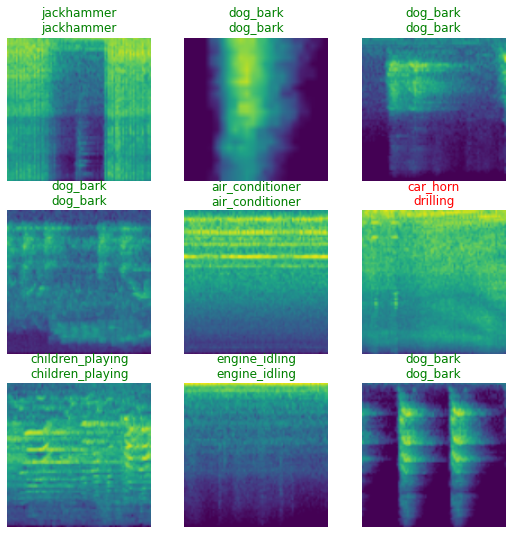

In [15]:
learn.show_results()

In [16]:
interp = Interpretation.from_learner(learn)

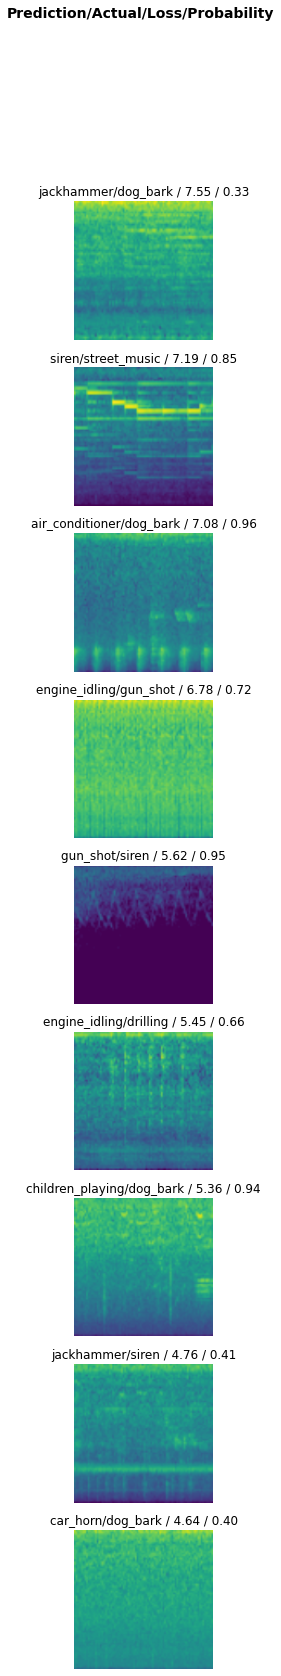

In [17]:
top_losses = interp.plot_top_losses(9,nrows=9)

This will give you the option to play the sound from top losses. This makes the notebook too big to be uploaded.
`losses,idxs = interp.top_losses(9)
top_losses = [(dls.valid_ds.items[x]) for x in idxs]
for x in top_losses:
    filename = Path(x.name.split(".")[0])
    directory = URBAN_SOUND_RECORDINGS / x.parent.name
    for file in os.listdir(directory):
        if str(filename) in file:
            print(f'{x.parent.name}')
            display(Audio(directory/file))`

In [18]:
a = ClassificationInterpretation.from_learner(learn)

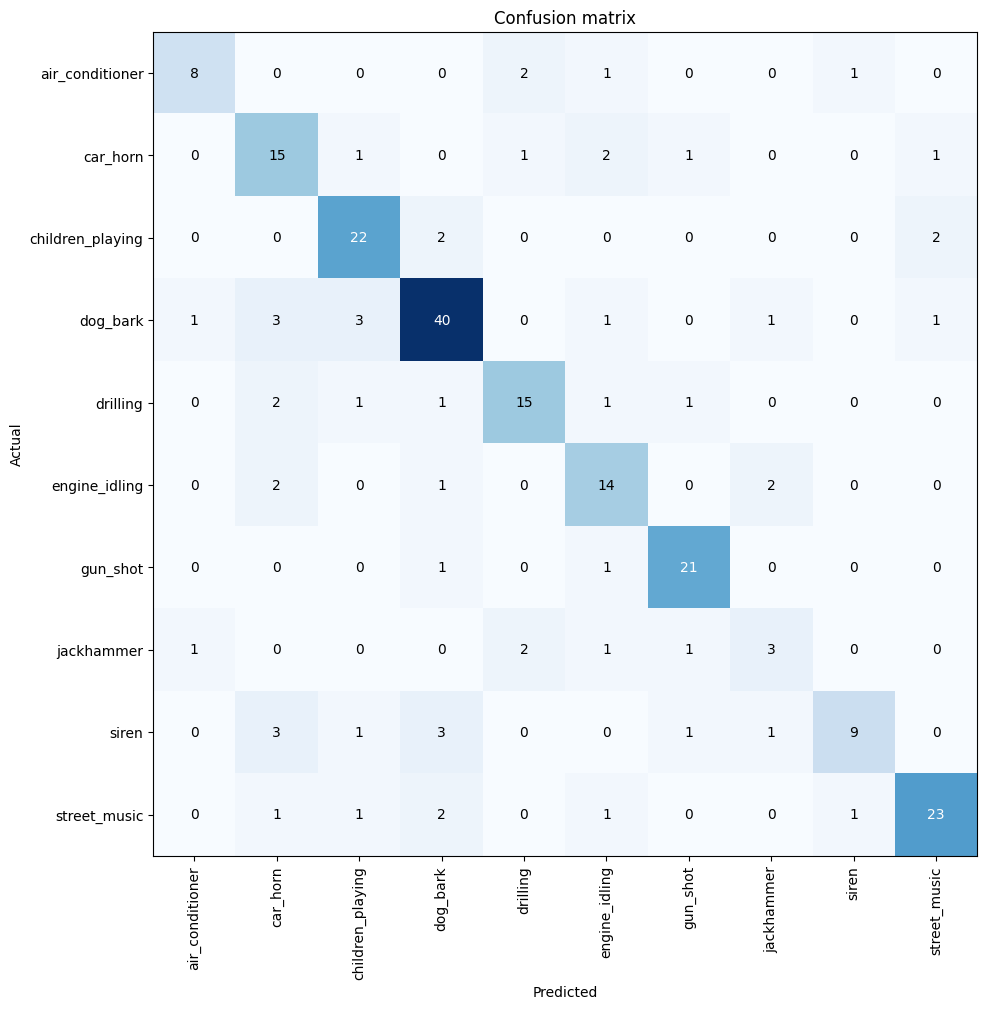

In [19]:
a.plot_confusion_matrix(figsize=(10,10), dpi = 100)

## Comparing using a base model

As we can see below, after some training using a base model, the model gets a little bit lower score than the previous model.

In [20]:
learnBase = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

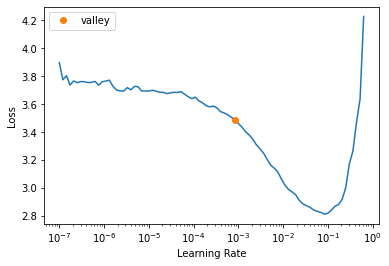

In [21]:
lr = learnBase.lr_find()

In [22]:
learnBase.fine_tune(8, lr.valley)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.476532,2.053450,0.660793,0.339207,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.707750,1.911830,0.634361,0.365639,00:01
1,2.568173,1.635401,0.506608,0.493392,00:01
2,2.309490,1.423573,0.444934,0.555066,00:01
3,2.054180,1.315374,0.409692,0.590308,00:01
4,1.851768,1.228010,0.392070,0.607930,00:01
5,1.732880,1.183828,0.383260,0.616740,00:01
6,1.628262,1.167527,0.387665,0.612335,00:01
7,1.546530,1.155276,0.383260,0.616740,00:01
